In [1]:
import sys
!{sys.executable} -m pip install colossus
!{sys.executable} -m pip install emcee
!{sys.executable} -m pip install corner

In [2]:
import numpy as np
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
import matplotlib as mpl
from scipy.optimize import curve_fit

import emcee
import corner

mpl.rcParams['agg.path.chunksize'] = 10000  # This is required to correctly plot the mass function evaluated on the data array



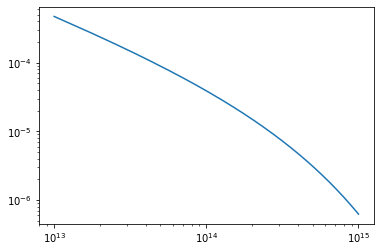

In [3]:

## cosmology.setCosmology('WMAP9') This is a default cosmology

params = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95} # This sets a customized cosmology
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

# Array of masses
m_arr = np.linspace(1E13,1E15,128)

##for mass in m_arr:
mfunc_so = mass_function.massFunction(m_arr, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM') # q_out modifies the output function
##    mfunc_fof = mass_function.massFunction(mass, 0.0, mdef = 'fof', model = 'watson13', q_out = dndlnM))
plt.loglog(m_arr,  mfunc_so)


plt.show()   

In [4]:
a = np.load('converted_catalog_z0.000_mock0001.npz') # Import the catalog and read through it
print(a.files)
print(a['mass'].shape) # a['masss] is an array with 2772758 components
print(a['mass'].shape)
print(np.max(a['mass']))
print(len(a['mass']))
print(np.max(a['pos']))

print(np.log10(np.e))
BoxVolume = np.amax(a['pos'])**3.

print(BoxVolume)

['mass', 'pos']
(2772758,)
(2772758,)
5705458771838476.0
2772758
3869.9985
0.4342944819032518
57960537183.56983


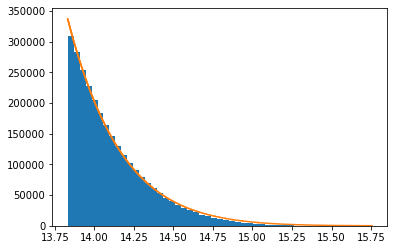

In [37]:
xmin = np.min(a['mass'])
xmax = np.max(a['mass'])
plt.hist(np.log10(a['mass']), bins=51, range = (np.log10(xmin), np.log10(xmax) ) )#Histogram of log-mass catalog, density=True gives a normalized histogram


m_arr = a['mass']
m_arr.sort() # order by increasing value
mfunc_so = mass_function.massFunction(m_arr, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')

plt.plot(np.log10(m_arr), BoxVolume*mfunc_so) 
plt.show()

[50.00001946  0.1         0.8       ]


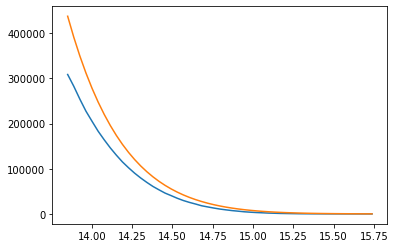

In [48]:
bin_heights, bin_borders = np.histogram(np.log10(a['mass']), bins=51, range = (np.log10(xmin), np.log10(xmax) ))
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

# Let us perform a preliminary fit
def func(x, a1, a2, a3):
    params = {'flat': True, 'H0': a1, 'Om0': a2, 'Ob0': 0.049,'sigma8': a3, 'ns': 0.95} # This sets a customized cosmology
    cosmology.addCosmology('myCosmofit', params)
    cosmo = cosmology.setCosmology('myCosmofit')
    mfunc_so = BoxVolume*mass_function.massFunction(x, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
    return mfunc_so


xdata = 10**(bin_centers)
ydata = bin_heights

popt, pcov = curve_fit(func, xdata, ydata, p0=[67., 0.3, 0.8], bounds=([50., 0.1, 0.1],[75, 0.5, 1.])) # Input params and bounds

print(popt) # Plot of estimated parameters (Terrible!)

plt.plot(np.log10(xdata), ydata)
plt.plot(np.log10(xdata), func(xdata, popt[0],popt[1], popt[2])) # Improvement needed, something starnge is happening
plt.show()